In [81]:
%matplotlib inline

# 1 Baseline

Считываем данные, строим baseline модель и рассматриваем разные метрики и графики для задачи классификации.

In [82]:
import warnings
warnings.filterwarnings("ignore")

In [83]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


### 1.1 Данные

In [98]:
data_train = pd.read_csv('data_train.csv', index_col=0)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 4 columns):
id          831653 non-null int64
vas_id      831653 non-null float64
buy_time    831653 non-null int64
target      831653 non-null float64
dtypes: float64(2), int64(2)
memory usage: 31.7 MB


In [99]:
data_train.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [100]:
data_test = pd.read_csv('data_test.csv', index_col=0)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71231 entries, 0 to 71230
Data columns (total 3 columns):
id          71231 non-null int64
vas_id      71231 non-null float64
buy_time    71231 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


In [101]:
data_test.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [103]:
%%time

features = pd.read_csv('features.csv', sep='\t', dtype='float32', index_col=0)
features['id'] = features['id'].astype('int32')
features['buy_time'] = pd.to_datetime(features['buy_time'], unit='s')
features.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4512528 entries, 0.0 to 4512527.0
Columns: 255 entries, id to 252
dtypes: datetime64[ns](1), float32(253), int32(1)
memory usage: 4.3 GB
Wall time: 11min 52s


In [105]:
features.index = features.index.astype('int32')

In [106]:
features.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-15 21:00:48,18.910028,46.980888,4.969214,-1.386798,3.791754,-14.011789,-16.08618,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-301.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
1,2014722,2018-10-14 21:00:48,36.690029,152.400894,448.069214,563.833191,463.841766,568.998230,-16.08618,-53.216099,...,-891.373840,-544.770813,-20.996269,48.369553,80.252274,-13.832889,-0.694429,-1.175933,-0.456140,0.0
2,2015199,2018-12-23 21:00:48,-67.019974,157.050888,-63.180786,178.103195,-68.598244,156.998215,3.51382,25.183903,...,-977.373840,-613.770813,-12.996268,-37.630447,10829.251953,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,2021765,2018-08-12 21:00:48,7.010029,150.200882,-6.930786,216.213196,76.621758,351.848206,-16.08618,-65.076096,...,-973.373840,-613.770813,-23.996269,-37.630447,-205.747726,-24.832888,-0.694429,-11.175933,-0.456140,1.0
4,2027465,2018-08-05 21:00:48,-90.439972,134.220886,-104.380783,153.643204,-109.798248,132.538208,-16.08618,-65.076096,...,1643.626099,2007.229248,206.003738,-21.630449,6667.252441,92.167114,-0.694429,49.824066,47.543861,0.0


In [14]:
# Разделим признаки и целевую переменную
data_prelim = data_train.copy()

X = data_prelim.drop('TARGET', axis=1)
y = data_prelim['TARGET']

In [15]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 20%


**У 20% признаков есть прощенные значения**

### 1.2 Разделяем на train и test

0    0.708454
1    0.291546
Name: TARGET, dtype: float64

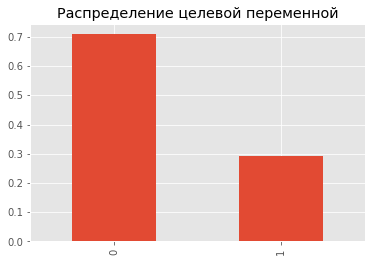

In [16]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [17]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0    0.709299
1    0.290701
Name: TARGET, dtype: float64

Test
0    0.705921
1    0.294079
Name: TARGET, dtype: float64


### 1.3 Pipeline для baseline модели

Для построения baseline модели будем использовать логистическую регрессию.

In [18]:
from sklearn.linear_model import LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))

В датасете порядка 20% признаков содержат пропущенные значения. Т.к. логистическая регрессия не умеет обрабатывать пропущенные значения, мы должны заполнить их сами. Для этого воспользуемся классом sklearn.impute.SimpleImputer. У этого класса есть параметр strategy, который определяет способ заполнения пропусков. Он может принимать несколько значений.

In [19]:
from sklearn.impute import SimpleImputer

In [20]:
SimpleImputer()

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

Для baseline модели выставим параметр strategy в значение mean.

In [21]:
step_imputer = ("imputer", SimpleImputer(strategy="mean"))

Базовый пайплайн будет состоять только из двух шагов:
- Заполнение пропусков средним
- Логистическая регрессия с базовыми параметрами

In [22]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_imputer,
    step_log_reg
])

### 1.4 Кросс-валидация

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

* Folds: 1 2 3
    * Train: 1,2 Val: 3
    * Train: 1,3 Val: 2
    * Train: 2,3 Val: 1

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Варианты:
- ‘precision’, ‘recall’, ‘accuracy’, ‘f1’
- ‘average_precision’, ‘roc_auc’

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [24]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.68 (+/- 0.02)


### 1.5 Графики и метрики baseline модели на тесте

In [25]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

#### Распределение предсказаний baseline модели

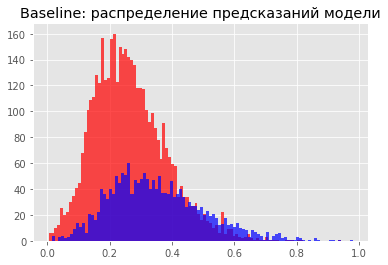

In [26]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [27]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.674


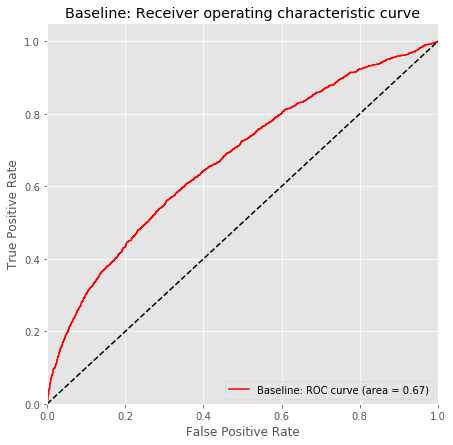

In [28]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.484


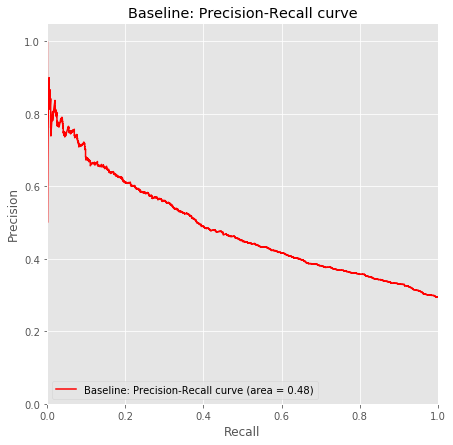

In [29]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Допустим, мы хотим построить классификатор, который будет находить не менее 80% multisim абонентов. Соответственно, имеем нижнюю границу 80% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога?

Максимальную точность при этом: 0.358
При каком пороге: 0.222


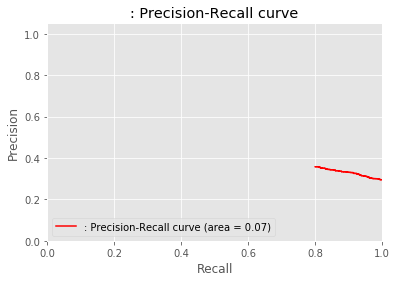

In [30]:
re80_mask = recall >= 0.8
pr_target_idx = np.arange(len(precision))[re80_mask]
pr_target = precision[re80_mask]

max_pr_idx = pr_target_idx[np.argmax(pr_target)]


print("Максимальную точность при этом: %.3f" % precision[max_pr_idx])
threshold80 = pr_thresholds[max_pr_idx]
print ("При каком пороге: %.3f" % threshold80)

plot_precision_recall_curve(recall[re80_mask], precision[re80_mask], color='r')

#### Матрица смежности

In [31]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[4163  165]
 [1511  292]]


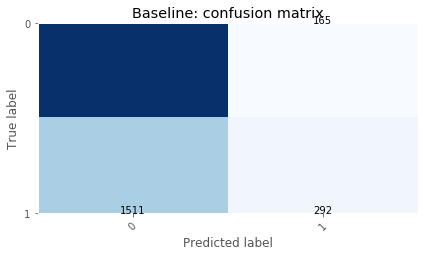

In [32]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      4328
           1       0.64      0.16      0.26      1803

    accuracy                           0.73      6131
   macro avg       0.69      0.56      0.55      6131
weighted avg       0.71      0.73      0.66      6131



In [34]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp)
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.73
           1 precision = 0.64
              1 recall = 0.16
   micro avg precision = 0.73 
   macro avg precision = 0.69 
weighted avg precision = 0.71 


# 2 Определение типа признаков

In [35]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [36]:
X_nunique.shape

(260,)

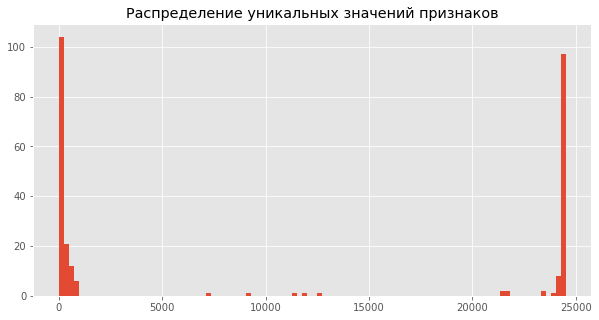

In [37]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [38]:
f_all = set(X_nunique.index.tolist())
len(f_all)

260

#### константные признаки

In [39]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

4

#### вещественные признаки

In [40]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

130

In [41]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

126

#### бинарные

In [42]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

14

In [43]:
f_other = f_other - f_binary
len(f_other)

112

#### категориальные

In [44]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical

In [45]:
f_other = f_other - f_categorical
len(f_other)

86

In [46]:
f_numeric = f_numeric | f_other

In [47]:
f_other = f_other - f_numeric
len(f_other)

0

In [48]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [49]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 260

f_const: 4
f_binary: 14
f_categorical: 26
f_numeric: 216


# 3 sklearn.Pipeline

Pipeline-ы выполняют последовательность transformer-ов и могут завершаться финальным estimator-ом. Все объектов transformer-ы должны иметь два метода - fit и transform. Финальный Estimator должын иметь метод fit.

### 3.1 Column Selector

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

In [51]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [52]:
cs_pipe = Pipeline([
    ('cs', ColumnSelector(columns=['FEATURE_0', 'FEATURE_90', 'FEATURE_193', 'FEATURE_154'])),
])

In [53]:
# cs_pipe.fit(X_train)

cs_pipe.transform(X_test).head()

,FEATURE_0,FEATURE_90,FEATURE_193,FEATURE_154
ID,,,,
58198991,0.0,-42.455826,NaN,0.0
437075004,0.0,41.479563,NaN,1.0
345260526,0.0,-43.313025,130.395302,1.0
749150565,3.0,226.743517,1184.360325,0.0
732888674,0.0,4.720634,NaN,1.0


### 3.2 Пайплайн обработки признаков

In [54]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [55]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [56]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['FEATURE_9', 'FEATURE_11', 'FEATURE_158', 'FEATURE_191',
                          'FEATURE_149', 'FEATURE_30', 'FEATURE_228',
                          'FEATURE_227', 'FEATURE_203', 'FEATURE_70',
                          'FEATURE_252', 'FEATURE_181', 'FEATURE_88',
                          'FEATURE_121', 'FEATURE_138', 'FEATURE_62',
                          'FEATURE_122', 'FEATURE_170', 'FEATURE_41',
                          'FEATURE_104', 'FEATURE_188', 'FEATURE_113',
                          'FEATURE_16', 'FEATURE_134', 'FEATURE_131',
                          'FEATURE_194', 'FEATURE_120', 'FEATURE_13',
                          'FEATURE_59', 'FEATURE_175', ...])),
 ('featureunion', FeatureUnion(n_jobs=None,
               transformer_list=[('numeric_features',
                                  Pipeline(memory=None,
                                           steps=[('columnselector',
                                                  

In [57]:
X_test.shape[1]

260

In [58]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

357

### 3.3 Gridsearch для пайплайнов

In [59]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

Про поиск имен параметров

In [62]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

In [63]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.70

Best parameters set found on development set:

{'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}

Grid scores on development set:

0.700 (+/-0.023) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}
0.701 (+/-0.022) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}



Сравним с baseline моделью, у которой roc_auc = 0.67 (+/- 0.02)

In [64]:
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.70

Best parameters set found on development set:

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}

Grid scores on development set:

0.696 (+/-0.014) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.703 (+/-0.023) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
0.704 (+/-0.025) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.702 (+/-0.023) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
0.699 (+/-0.023) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.699 (+/-0.023) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}



In [65]:
lg_gsc.best_params_

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}

### 3.4 Отбор признаков в пайплайнах

In [66]:
from sklearn.feature_selection import SelectFromModel

Атрибут estimator класса SelectFromModel должен иметь хотя бы один из атрибутов feature_importances_ или coef_ после выполнения метода fit.

In [67]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE), threshold=1e-5),
)

In [68]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(6131, 357)

In [69]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(6131, 272)

Логистическая регрессия из SelectFromModel обнулила около 23% признаков.

In [70]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [71]:
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.70

Best parameters set found on development set:

{'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.700 (+/-0.023) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.617 (+/-0.016) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.643 (+/-0.025) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.693 (+/-0.021) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.697 (+/-0.021) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.698 (+/-0.022) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.700 (+/-0.023) for {'selectfrommodel__threshold': 1e-05}



# 4 Финальная модель

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE), threshold=1e-5),
    GradientBoostingClassifier()
)

In [74]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_impurity_split',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__presort',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingclassifier__warm_start']

In [75]:
param_grid = {
    "selectfrommodel__threshold": [-np.inf, 1e-05],
    
    "gradientboostingclassifier__max_depth": [1, 5],
    "gradientboostingclassifier__n_estimators": [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.71

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.654 (+/-0.011) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.654 (+/-0.011) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.698 (+/-0.012) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}
0.698 (+/-0.011) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}
0.695 (+/-0.007) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.695 (+

### 4.1 Сравнение моделей

In [76]:
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

In [77]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      4328
           1       0.61      0.26      0.37      1803

    accuracy                           0.73      6131
   macro avg       0.68      0.60      0.60      6131
weighted avg       0.71      0.73      0.69      6131



In [78]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:,1]

In [79]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84      4328
           1       0.65      0.27      0.38      1803

    accuracy                           0.74      6131
   macro avg       0.70      0.60      0.61      6131
weighted avg       0.72      0.74      0.70      6131



Baseline: AUC_PR = 0.484
Baseline: AUC_ROC = 0.674
lg_fs_pred: AUC_PR = 0.510
lg_fs_pred: AUC_ROC = 0.692
gb_fs_pred: AUC_PR = 0.552
gb_fs_pred: AUC_ROC = 0.720


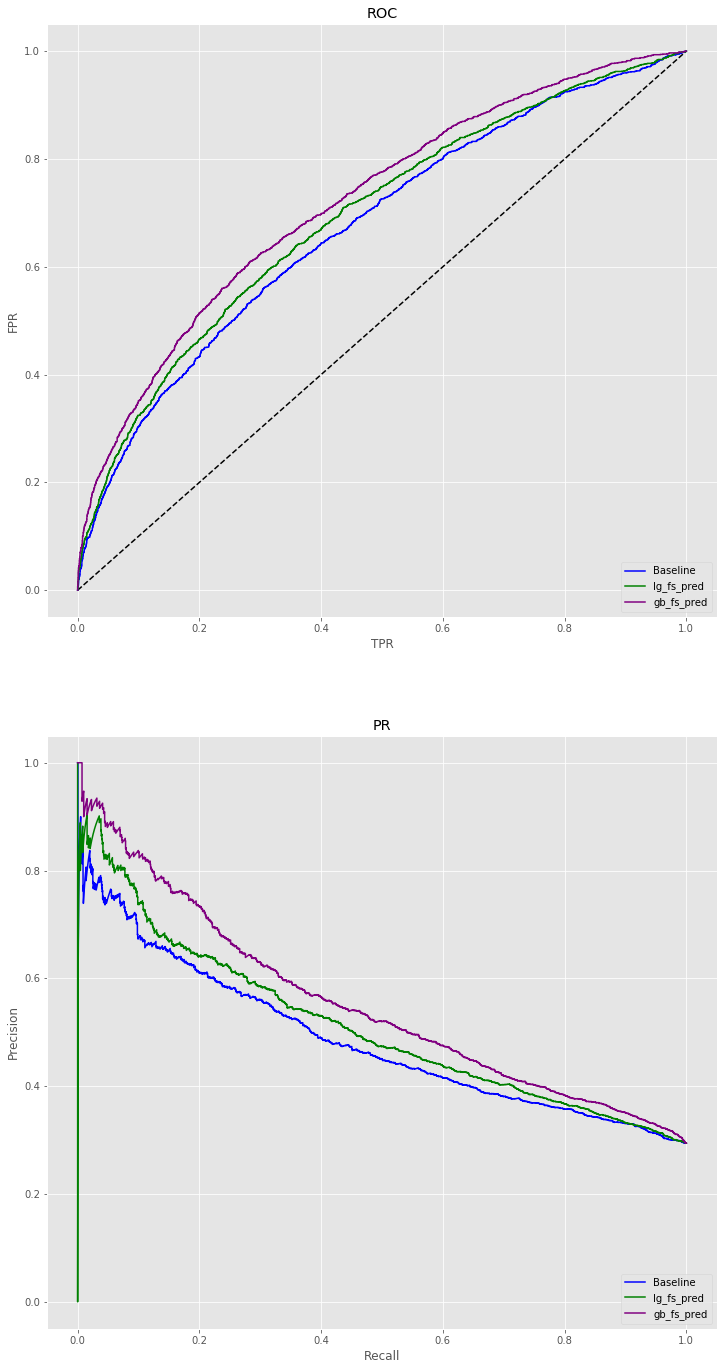

In [80]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label="gb_fs_pred", color='purple')
ax2.plot(recall, precision, label="gb_fs_pred", color='purple')
print("gb_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("gb_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");